# Sensitivity to parameters

This notebook contains methods and results for performing sensitivity analysis. This analysis was used to create results and figures for the final paper.

----

### Imports

In [162]:
import numpy as np
import pandas as pd
import scipy as sp
import time
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
%matplotlib inline

### The system of equations

In [163]:
def opioid(state, t, alpha, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star):
    S, P, A, R = state
    S_prime = -alpha*S - beta*(1-xi)*S*A - beta*xi*S*P + epsilon*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (epsilon + gamma + mu)*P
    A_prime = gamma*P + sigma*R + beta*(1-xi)*S*A + beta*xi*S*P + nu*R*A - (zeta + mu_star)*A
    R_prime = zeta*A - nu*R*A - (delta + sigma + mu)*R
    return [S_prime, P_prime, A_prime, R_prime]

### Our modified version

In [164]:
def opioid(state, t, epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star):
    
    '''
    modification 1: nu A is assumed to be 1 - sigma - delta - mu
    
    modification 2: beta and xi are replaced with beta_1 and beta_2 
    
    epsilon may also be assumed to be 1 - gamma to simplify parameter space, but is not employed here
    
    '''
    S, P, A, R = state

    # System of differential equations
    S_prime = -alpha*S - beta_1*S*A - beta_2*S*P + (epsilon)*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (epsilon + gamma + mu)*P
    A_prime = gamma*P + beta_1*S*A + beta_2*S*P + R*(1 - delta - mu) - (zeta + mu_star)*A
    R_prime = zeta*A - R
    
    # Return derivatives
    return [S_prime, P_prime, A_prime, R_prime]

### Our initial parameters

In [165]:
# parameters
epsilon = 0.74 # Prescribed to Susceptible rate
mu = 0.00824 # death rate
mu_star = 0.00834 # death rate of addicts
delta = 0.1 # R to S rate. 0.1 is default
gamma = 0.1
beta_1 = 0.05
beta_2 = 0.1
alpha = 0.05 # prescription rate. could be 0-1
zeta = 0.5 # rate of A entry into quitting or rehab. could be 0-1


### Define ranges for input parameters

In [166]:
problem = {
  'num_vars': 9,
  'names': ['epsilon','alpha', 'beta_1','beta_2','gamma', 'zeta', 'delta', 'mu', 'mu_star'],
  'bounds': [[0,1],[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0,1], [0, 0.01], [0, 0.05]]
}
# Generate samples
param_values = saltelli.sample(problem, 1000, calc_second_order=True)


In [167]:
param_values.shape

(20000, 9)

### Functions to return final infected states given input parameter values

In [168]:
def getFinalAddiction(params):
    
    '''Returns size of Addiction class after 1000 years'''
    # times to solve at
    t = np.linspace(0, 1000, 10000) # "equilibrium" is defined to be 1000 years
    
    # initial state
    state0 = [0.82, 0.15, 0.02, 0.01]

    final_addiction_rate = []
    
    # loop through each set of sampled parameters, and calculate the solution
    for row in params:
        epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star = row
        
        # solve state, t, 
        numerical_sol = sp.integrate.odeint(opioid, state0, t, args=(epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star))
        A = numerical_sol[:,2]
        R = numerical_sol[:,3]
        final_addiction_rate.append(A[-1])
        
    # return endemic addiction rate
    return np.array(final_addiction_rate )

def getFinalInfected(params):
    '''Returns size of combined Addiction + Recovery classes after 1000 years'''
    # times to solve at
    t = np.linspace(0, 1000, 10000) # "equilibrium" is defined to be 1000 years
    
    # initial state
    state0 = [0.82, 0.15, 0.02, 0.01]

    final_addiction_rate = []
    
    # loop through each set of sampled parameters, and calculate the solution
    for row in params:
        epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star = row
        
        # solve state, t, 
        numerical_sol = sp.integrate.odeint(opioid, state0, t, args=(epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star))
        A = numerical_sol[:,2]
        R = numerical_sol[:,3]
        final_addiction_rate.append(A[-1]+R[-1])
        
    # return endemic addiction rate
    return np.array(final_addiction_rate )

### Perform sensitivity analysis - Sensitivity of parameters to Size of Addiction Class at Equilibrium

In [186]:
# Run model (example)
Y = getFinalAddiction(param_values)

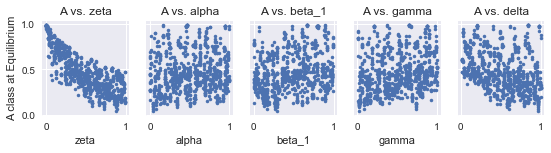

In [187]:
# take the first n parameters to plot
n = 1000
zetas = param_values[0:n,5]
alphas = param_values[:n,1]
beta1s = param_values[:n,2]
gammas = param_values[:n,4]
deltas = param_values[:n,6]

# plot figures to look at scatterplots of addiction and zeta, alapha, beta1, and gamma

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize = (9,1.75))
ax1.plot(zetas, Y[0:n], '.')
ax1.set_xlabel("zeta")
ax2.set_xlabel("alpha")
ax3.set_xlabel("beta_1")
ax4.set_xlabel("gamma")
ax1.set_title('A vs. zeta')
ax1.set_ylabel("A class at Equilibrium")
ax2.plot(alphas, Y[0:n], '.')
ax2.set_title('A vs. alpha')
ax3.plot(beta1s, Y[0:n], '.')
ax3.set_title('A vs. beta_1')
ax4.plot(gammas, Y[0:n], '.')
ax4.set_title('A vs. gamma')
ax5.plot(deltas, Y[0:n], '.')
ax5.set_title('A vs. delta')

plt.savefig('sensitivity_scatterplots_.png')

In [175]:
# Print sets of parameters that led to low states of addicted
low_addiction = param_values[Y<0.1][0:10]
low_addiction

array([[  4.21386719e-01,   7.17773438e-02,   1.71386719e-01,
          2.36816406e-01,   8.83789062e-02,   8.82324219e-01,
          6.06933594e-01,   1.04980469e-03,   2.23876953e-02],
       [  3.58886719e-01,   5.09277344e-01,   1.35253906e-01,
          1.44042969e-01,   2.58789062e-02,   5.69824219e-01,
          7.94433594e-01,   4.17480469e-03,   5.12695313e-04],
       [  8.45214844e-01,   4.05273438e-02,   2.91503906e-01,
          5.80566406e-01,   2.58789062e-02,   8.75488281e-01,
          9.60449219e-01,   5.56152344e-03,   2.02636719e-03],
       [  8.45214844e-01,   3.45214844e-01,   2.91503906e-01,
          3.62792969e-01,   2.58789062e-02,   8.75488281e-01,
          9.60449219e-01,   5.56152344e-03,   2.02636719e-03],
       [  8.45214844e-01,   4.05273438e-02,   2.65136719e-01,
          3.62792969e-01,   7.44628906e-01,   7.26074219e-01,
          5.75683594e-01,   8.23730469e-03,   4.58251953e-02],
       [  2.65136719e-01,   4.05273438e-02,   2.65136719e-01,
   

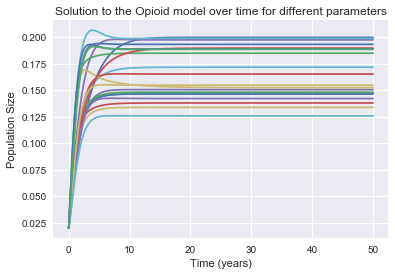

In [176]:
for i, row in enumerate(param_values[Y<0.2][0:20]):
    epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star = row
    
    # times to solve at
    t = np.linspace(0, 50, 160)
    
    # initial state
    state0 = [0.82, 0.15, 0.02, 0.01]
    numerical_sol, output = sp.integrate.odeint(opioid, state0, t, full_output=1,args=(epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star))
    S = numerical_sol[:,0]
    P = numerical_sol[:,1]
    A = numerical_sol[:,2]
    R = numerical_sol[:,3]

    plt.plot(t, A, label= "Zeta = %s" %round(zeta,2))
    plt.title("Solution to the Opioid model over time for different parameters")
    plt.xlabel("Time (years)")
    plt.ylabel("Population Size")
    #plt.legend()


### Perform Sobol sensitivity analysis

In [177]:
# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=False)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)

In [178]:
second_order_effects = pd.DataFrame(Si['S2'].round(3))
second_order_effects.columns = ['epsilon','alpha', 'beta_1', 'beta_2', 'gamma', 'zeta', 'delta', 'mu', 'mu_star']
second_order_effects.index = second_order_effects.columns
second_order_effects

,epsilon,alpha,beta_1,beta_2,gamma,zeta,delta,mu,mu_star
epsilon,NaN,0.002,0.005,0.002,0.005,0.006,0.002,0.002,0.002
alpha,NaN,NaN,0.005,-0.008,-0.002,-0.002,-0.007,-0.008,-0.009
beta_1,NaN,NaN,NaN,0.017,0.018,0.027,0.020,0.016,0.018
beta_2,NaN,NaN,NaN,NaN,-0.002,-0.004,-0.003,-0.004,-0.004
gamma,NaN,NaN,NaN,NaN,NaN,0.007,0.005,0.006,0.007
zeta,NaN,NaN,NaN,NaN,NaN,NaN,0.007,0.001,-0.001
delta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009,-0.009
mu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
mu_star,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
results = pd.DataFrame({
    "parameter": ['epsilon','alpha', 'beta_1', 'beta_2', 'gamma', 'zeta', 'delta', 'mu', 'mu_star'],
    "first-order effect": Si['S1'].round(3),
    "total-order effect": Si['ST'].round(3)
})
#Si['S1']
results.sort(columns="first-order effect", ascending=False)

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,first-order effect,parameter,total-order effect
5,0.707,zeta,0.740
6,0.150,delta,0.164
4,0.032,gamma,0.048
2,0.024,beta_1,0.065
1,0.022,alpha,0.042
3,0.005,beta_2,0.007
8,0.004,mu_star,0.006
7,-0.000,mu,0.000
0,-0.002,epsilon,0.006


### Repeat sensitivity analysis with output as Size of A + R at Equilibrium

In [180]:
# Run model (example)
Y = getFinalInfected(param_values)

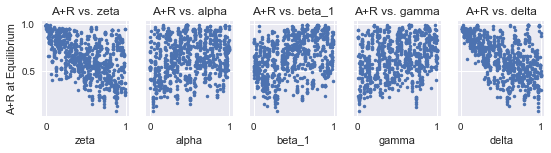

In [184]:
# take the first n parameters to plot
n = 1000
zetas = param_values[0:n,5]
alphas = param_values[:n,1]
beta1s = param_values[:n,2]
gammas = param_values[:n,4]
deltas = param_values[:n,6]

# plot figures to look at scatterplots of addiction and zeta, alapha, beta1, and gamma

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize = (9,1.75))
ax1.plot(zetas, Y[0:n], '.')
ax1.set_xlabel("zeta")
ax2.set_xlabel("alpha")
ax3.set_xlabel("beta_1")
ax4.set_xlabel("gamma")
ax5.set_xlabel("delta")
ax1.set_title('A+R vs. zeta')
ax1.set_ylabel("A+R at Equilibrium")
ax2.plot(alphas, Y[0:n], '.')
ax2.set_title('A+R vs. alpha')
ax3.plot(beta1s, Y[0:n], '.')
ax3.set_title('A+R vs. beta_1')
ax4.plot(gammas, Y[0:n], '.')
ax4.set_title('A+R vs. gamma')
ax5.plot(deltas, Y[0:n], '.')
ax5.set_title('A+R vs. delta')

plt.savefig('sensitivity_scatterplots_infected.png')

In [182]:
# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=False)

# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)


second_order_effects = pd.DataFrame(Si['S2'].round(3))
second_order_effects.columns = ['epsilon','alpha', 'beta_1', 'beta_2', 'gamma', 'zeta', 'delta', 'mu', 'mu_star']
second_order_effects.index = second_order_effects.columns
print("Second Order Effects")
second_order_effects

Second Order Effects


,epsilon,alpha,beta_1,beta_2,gamma,zeta,delta,mu,mu_star
epsilon,NaN,0.001,0.008,0.002,0.009,0.008,0.001,0.002,0.002
alpha,NaN,NaN,0.008,-0.017,-0.004,-0.008,-0.016,-0.018,-0.020
beta_1,NaN,NaN,NaN,0.022,0.025,0.028,0.032,0.022,0.023
beta_2,NaN,NaN,NaN,NaN,-0.006,-0.007,-0.008,-0.010,-0.011
gamma,NaN,NaN,NaN,NaN,NaN,0.021,0.009,0.016,0.016
zeta,NaN,NaN,NaN,NaN,NaN,NaN,0.039,-0.002,-0.003
delta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.015,-0.014
mu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000
mu_star,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
results = pd.DataFrame({
    "parameter": ['epsilon','alpha', 'beta_1', 'beta_2', 'gamma', 'zeta', 'delta', 'mu', 'mu_star'],
    "first-order effect": Si['S1'].round(3),
    "total-order effect": Si['ST'].round(3)
})
#Si['S1']
results.sort(columns="first-order effect", ascending=False)

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,first-order effect,parameter,total-order effect
6,0.367,delta,0.419
5,0.273,zeta,0.352
4,0.074,gamma,0.111
2,0.058,beta_1,0.130
1,0.052,alpha,0.101
3,0.012,beta_2,0.016
8,0.006,mu_star,0.009
7,0.000,mu,0.000
0,-0.003,epsilon,0.013
